In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

#### loading model and data

an example was taken from
https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html

In [2]:
# load pre-trained model and data
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

In [3]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))
# print("Class names:", class_names)

Number of ImageNet classes: 1000


In [4]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker, output_names=class_names)

shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

Partition explainer: 3it [00:32, 16.24s/it]               


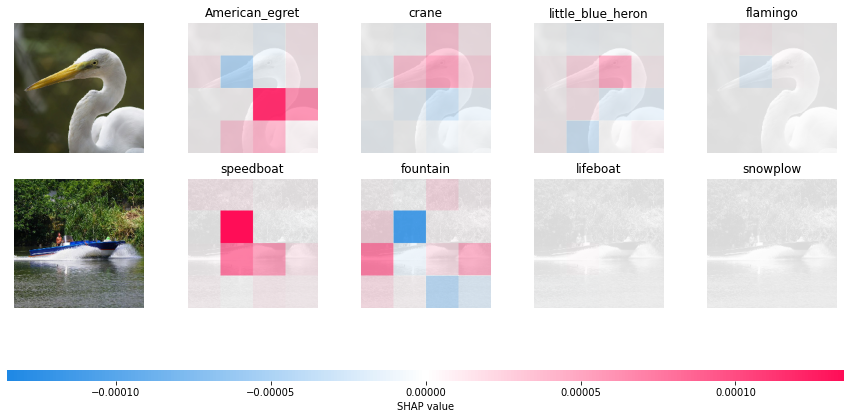

In [5]:
shap.image_plot(shap_values)

outputs=shap.Explanation.argsort.flip[:4] code gets only 4 most probable cases classes. That is why for the original class we got classes: "crane", "little blue heron", and flamingo. All of them are pretty close to "American_egret" from visual point of view, as well as from distances between embeddings in the neural network

Lets increase max_evals parameter for a more detailed explaination. It took a while:)

In [6]:
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

Partition explainer: 3it [11:29, 344.95s/it]              


In [9]:
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:6])

Partition explainer: 3it [10:19, 309.59s/it]              


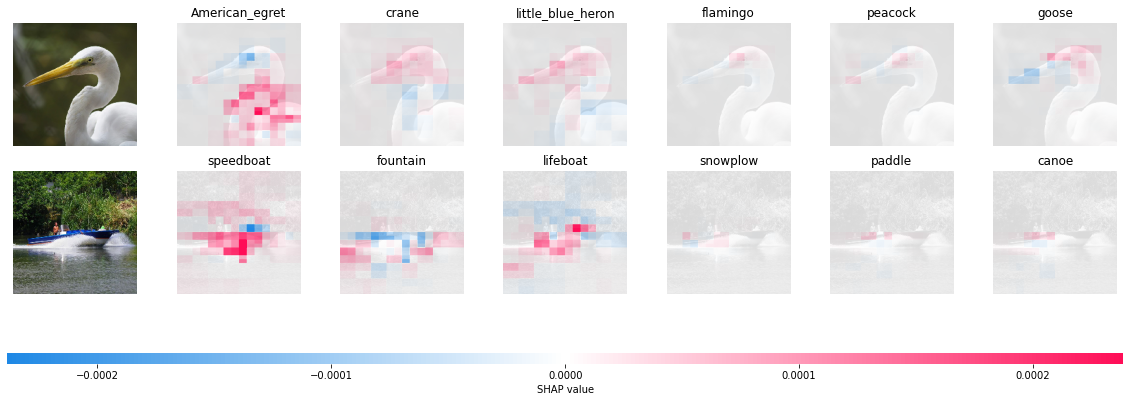

In [10]:
# output with shap values
shap.image_plot(shap_values_fine, show=True)

We can see that there is a neck on the bird picture, and it is the distinctive feature for classifying the image as American egret, but not Crane, Heron or a Flamingo, because threre are a lot of red points in this region. Crane and littel blue heron have blue pixels there which means that they have negative SHAP value because of these regions


It is the surface between the boat and the water that defined the speedboat class. We can see that fountain class does not have it, while lifeboat is different by it's form-factor and color (take a look at blue pixels in that area)

Also when I printed 6 closest classes, the goose appeared, and we can clearly see that the nose with all blue regions was the main obstacle to be classified as goose:)